In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [2]:
# Non linear system
def Non_linear_linearisable(S,t,mu,sigma):
    x_1 = mu*(S[0]);
    x_2 = sigma*(S[1]-S[0]**2);
    dS  = np.array([x_1,x_2]);
    return dS

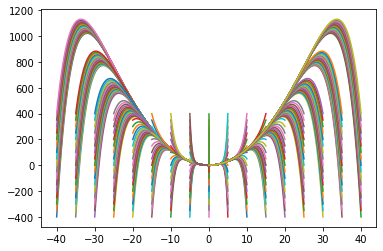

In [3]:
# data
mu =  -1
sigma = -10
dt   = 0.01
Tend = 6

x0 = np.array([[12.0,-1.0]]);
dim = x0.shape[-1]
S_train = []
for i in range(x0.shape[0]):
    S_train.append(odeint(Non_linear_linearisable,x0[i,:],np.arange(0,Tend+0.000001,dt),args=(mu,sigma)));

xi0 = np.arange(-40,41,5)
yi0 = np.arange(-400,410,50)
xv, yv = np.meshgrid(xi0, yi0, sparse=False, indexing='ij')
x0 = np.concatenate((xv.reshape(-1,1),yv.reshape(-1,1)),axis = -1)
dim = x0.shape[-1]
S_test = []
for i in range(x0.shape[0]):
    S_test.append(odeint(Non_linear_linearisable,x0[i,:],np.arange(0,Tend+0.000001,dt),args=(mu,sigma)));

S_train = np.array(S_train)
S_test = np.array(S_test)

for i in range(0,S_test.shape[0]):
    plt.plot(S_test[i,:,0],S_test[i,:,1])

# DMD and EDMD data definition, EDMD observables : (z0,z1,z0^2)

In [4]:
Batch_size = S_train.shape[1]
X_train = S_train[:,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = S_train.shape[0]
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
X_test  = torch.from_numpy(X_test).double()
Train_X_DMD = X_train[:,:-1,:].reshape(-1,2).numpy()
Train_Y_DMD = X_train[:,1:,:].reshape(-1,2).numpy()

In [5]:
Train_X_EDMD = np.zeros((Train_X_DMD.shape[0],3))
Train_X_EDMD[:,0] = Train_X_DMD[:,0]
Train_X_EDMD[:,1] = Train_X_DMD[:,1]
Train_X_EDMD[:,2] = Train_X_DMD[:,0]**2
Train_Y_EDMD = np.zeros((Train_X_DMD.shape[0],3))
Train_Y_EDMD[:,0] = Train_Y_DMD[:,0]
Train_Y_EDMD[:,1] = Train_Y_DMD[:,1]
Train_Y_EDMD[:,2] = Train_Y_DMD[:,0]**2

In [6]:
A_DMD  = np.dot(np.linalg.pinv(Train_Y_DMD),Train_X_DMD).T

In [7]:
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD),Train_Y_EDMD).T

In [8]:
A_DMD

array([[ 1.01005017e+00,  2.94927876e-13],
       [-6.04432671e-01,  1.07228830e+00]])

In [9]:
A_EDMD

array([[ 9.90049834e-01, -1.79071168e-13, -3.16696756e-13],
       [ 5.92937813e-09,  9.04837417e-01,  9.42015688e-02],
       [ 3.05696701e-11, -1.30760550e-12,  9.80198673e-01]])

In [10]:
pred_DMD  = np.zeros_like(X_test)
pred_EDMD = np.zeros((X_test.shape[0],X_test.shape[1],3))# np.zeros_like(X_test)
pred_DMD[:,:3]  = X_test[:,:3,:]
pred_EDMD[:,:3,:2] = X_test[:,:3,:]
pred_EDMD[:,:3,2]  = pred_EDMD[:,:3,0]**2 
for j in range(X_test.shape[0]):
    for i in range(X_test.shape[1]):
        pred_DMD[j,3+i:3+i+1,:] = np.dot(A_DMD,pred_DMD[j,3+i-1:3+i,:].T).T
        pred_EDMD[j,3+i:3+i+1,:] = np.dot(A_EDMD,pred_EDMD[j,3+i-1:3+i,:].T).T

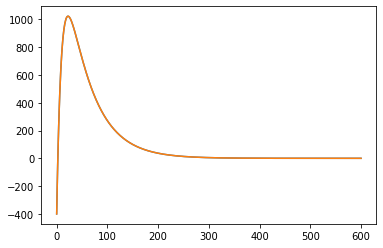

In [11]:
plt.plot(pred_EDMD[0,:1000,1])
plt.plot(X_test[0,:1000,1])

In [12]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy() 
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['pred_EDMD'] = pred_EDMD
out_res['pred_DMD'] = pred_DMD

file_name_results = 'DMD_EDMD_EQ_Point_good_observable'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results") 

pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/DMD_EDMD_EQ_Point_good_observable/  already exists, overwriting results


In [13]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

Text(0, 0.5, '${\\mathrm{z}}_{2,t}$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


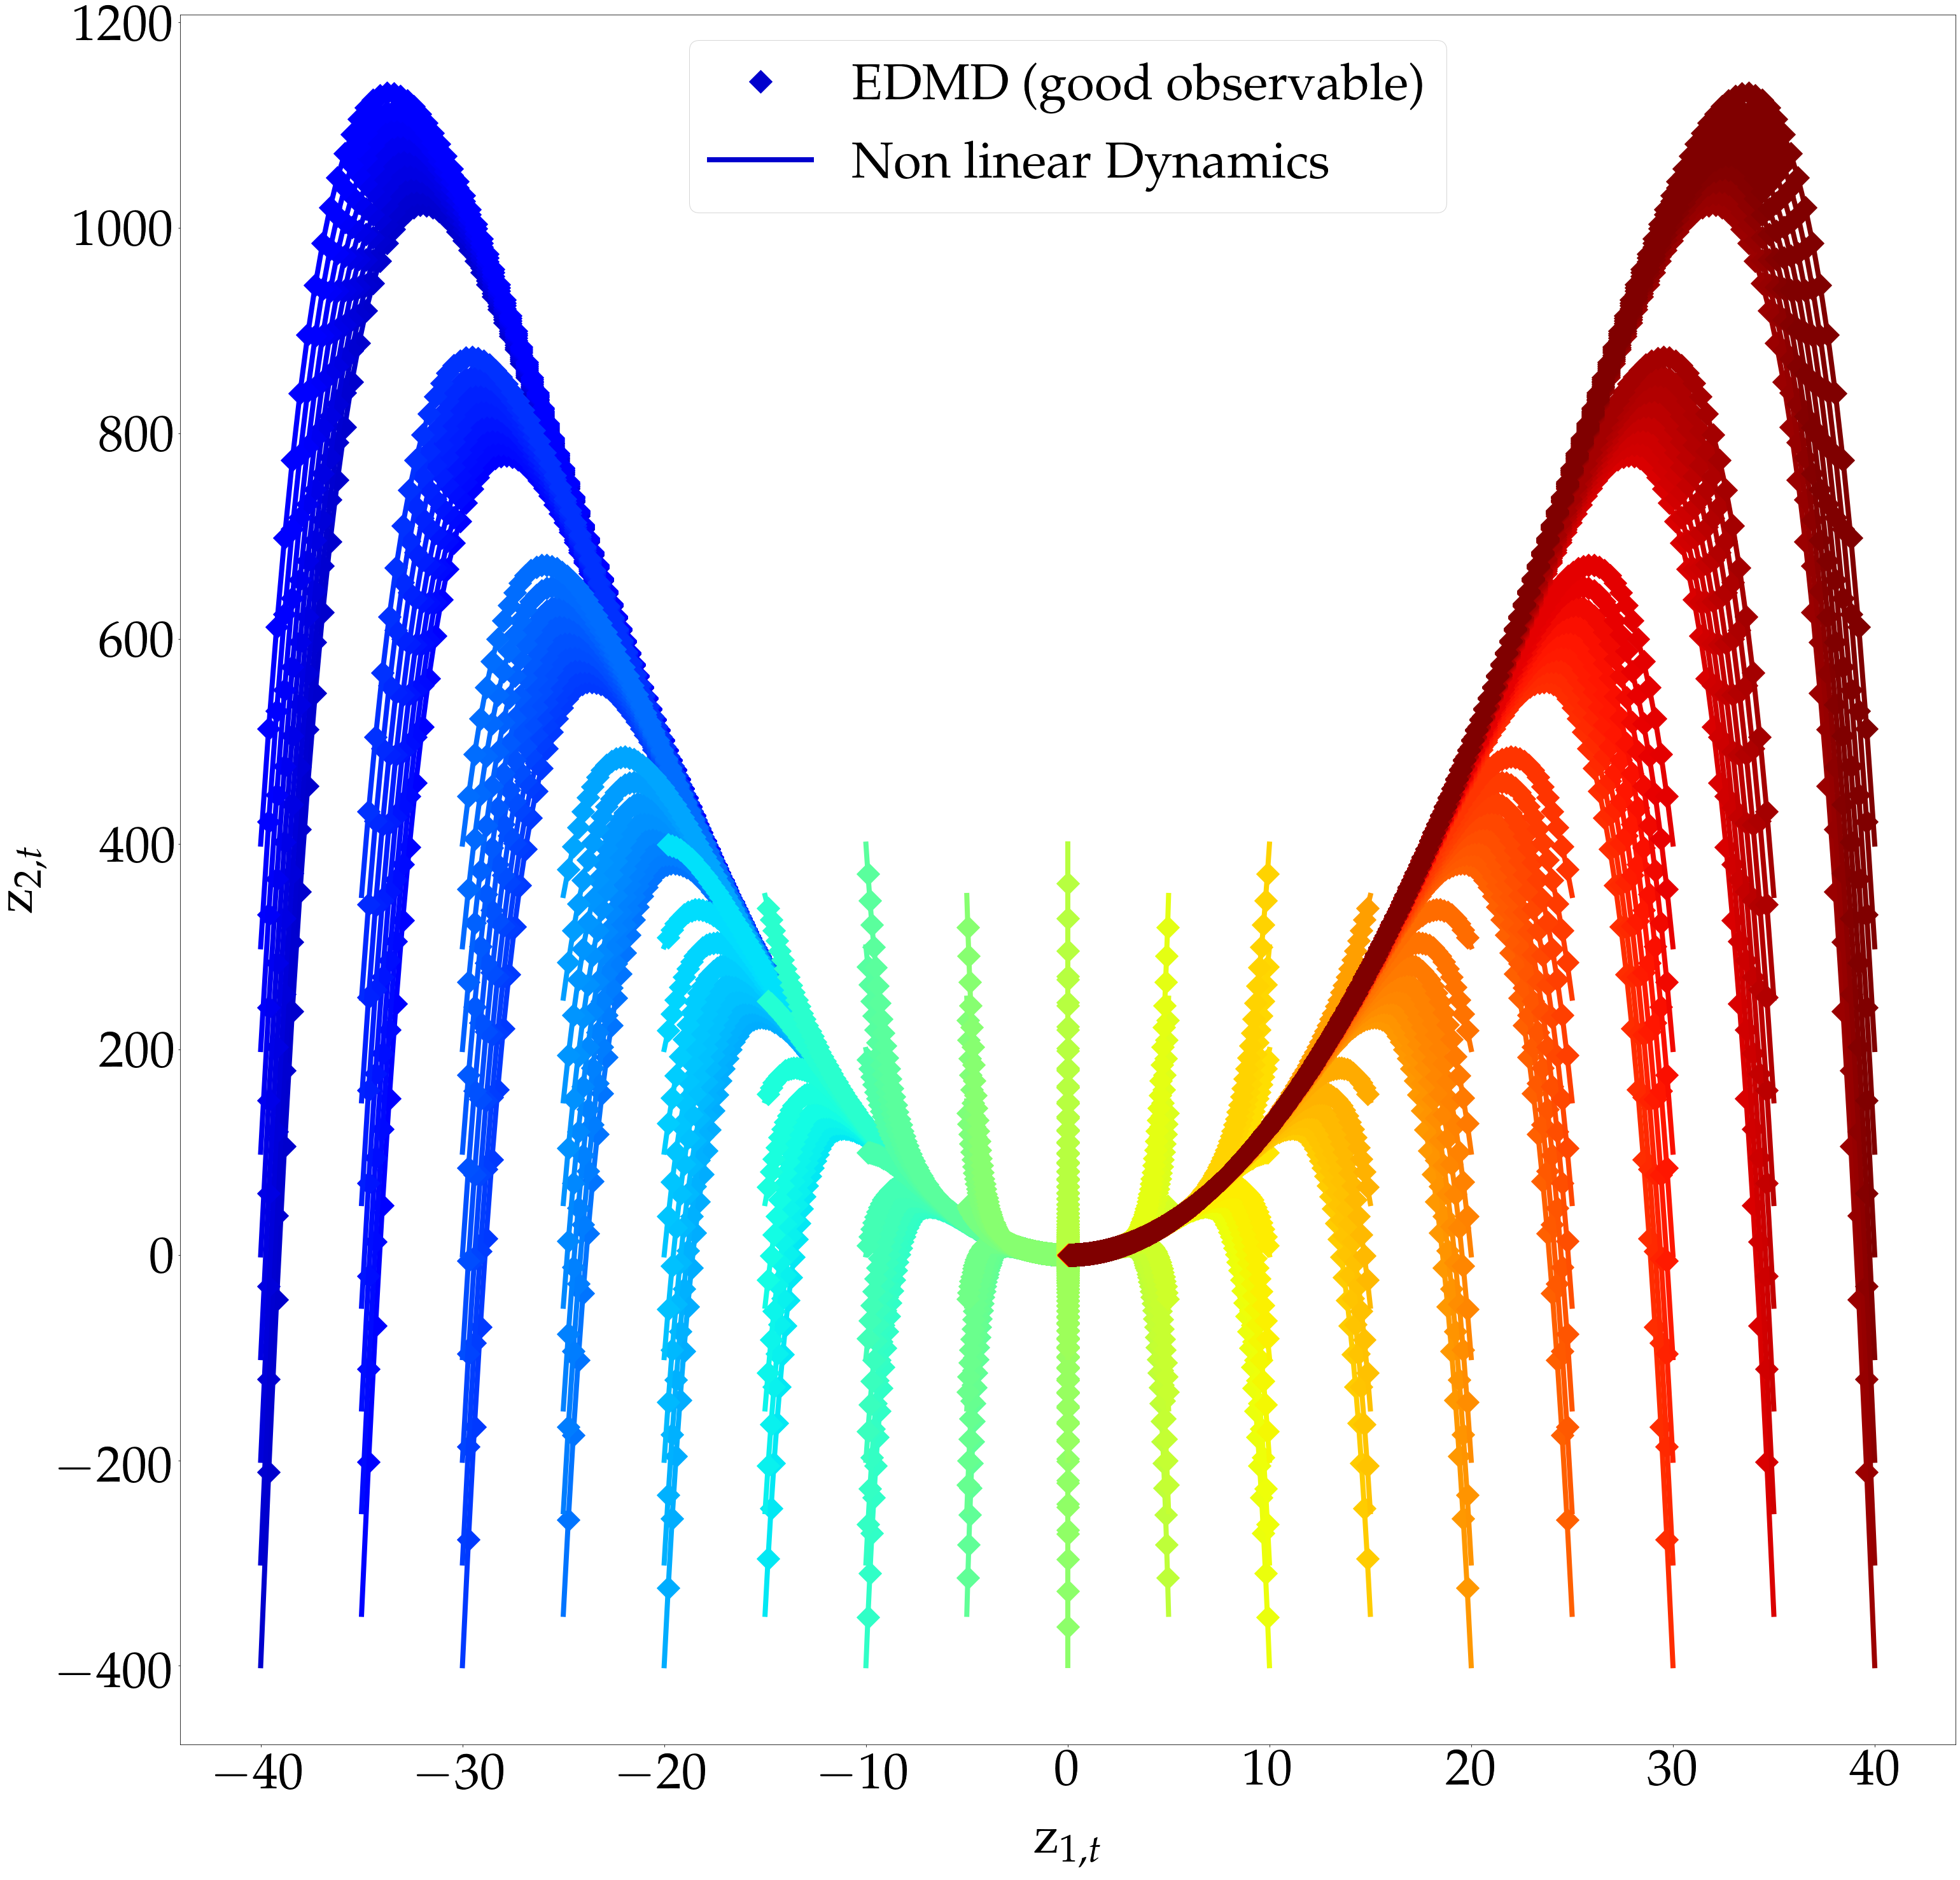

In [14]:
threshholded_pred = res['pred_EDMD']
threshholded_test = res['test_data']
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
cmap = plt.get_cmap('jet')
fig=plt.figure(figsize=(50,50))
for i in range(0,threshholded_pred.shape[0],2):
    color = cmap(float(i+20)/300)
    plt.plot(threshholded_pred[i,1:,0],threshholded_pred[i,1:,1],"D",markersize=25,c = color)
    plt.plot(threshholded_test[i,:,0],threshholded_test[i,:,1],c = color,lw = 8)
plt.plot(threshholded_pred[i,1:,0]*np.nan,threshholded_pred[i,1:,1]*np.nan,"D",markersize=25,c = cmap(float(0+20)/300),label = 'EDMD (good observable)')
plt.plot(threshholded_test[i,:,0]*np.nan,threshholded_test[i,:,1]*np.nan,c = cmap(float(0+20)/300),lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')


Text(0, 0.5, '${\\mathrm{z}}_{2,t}$')

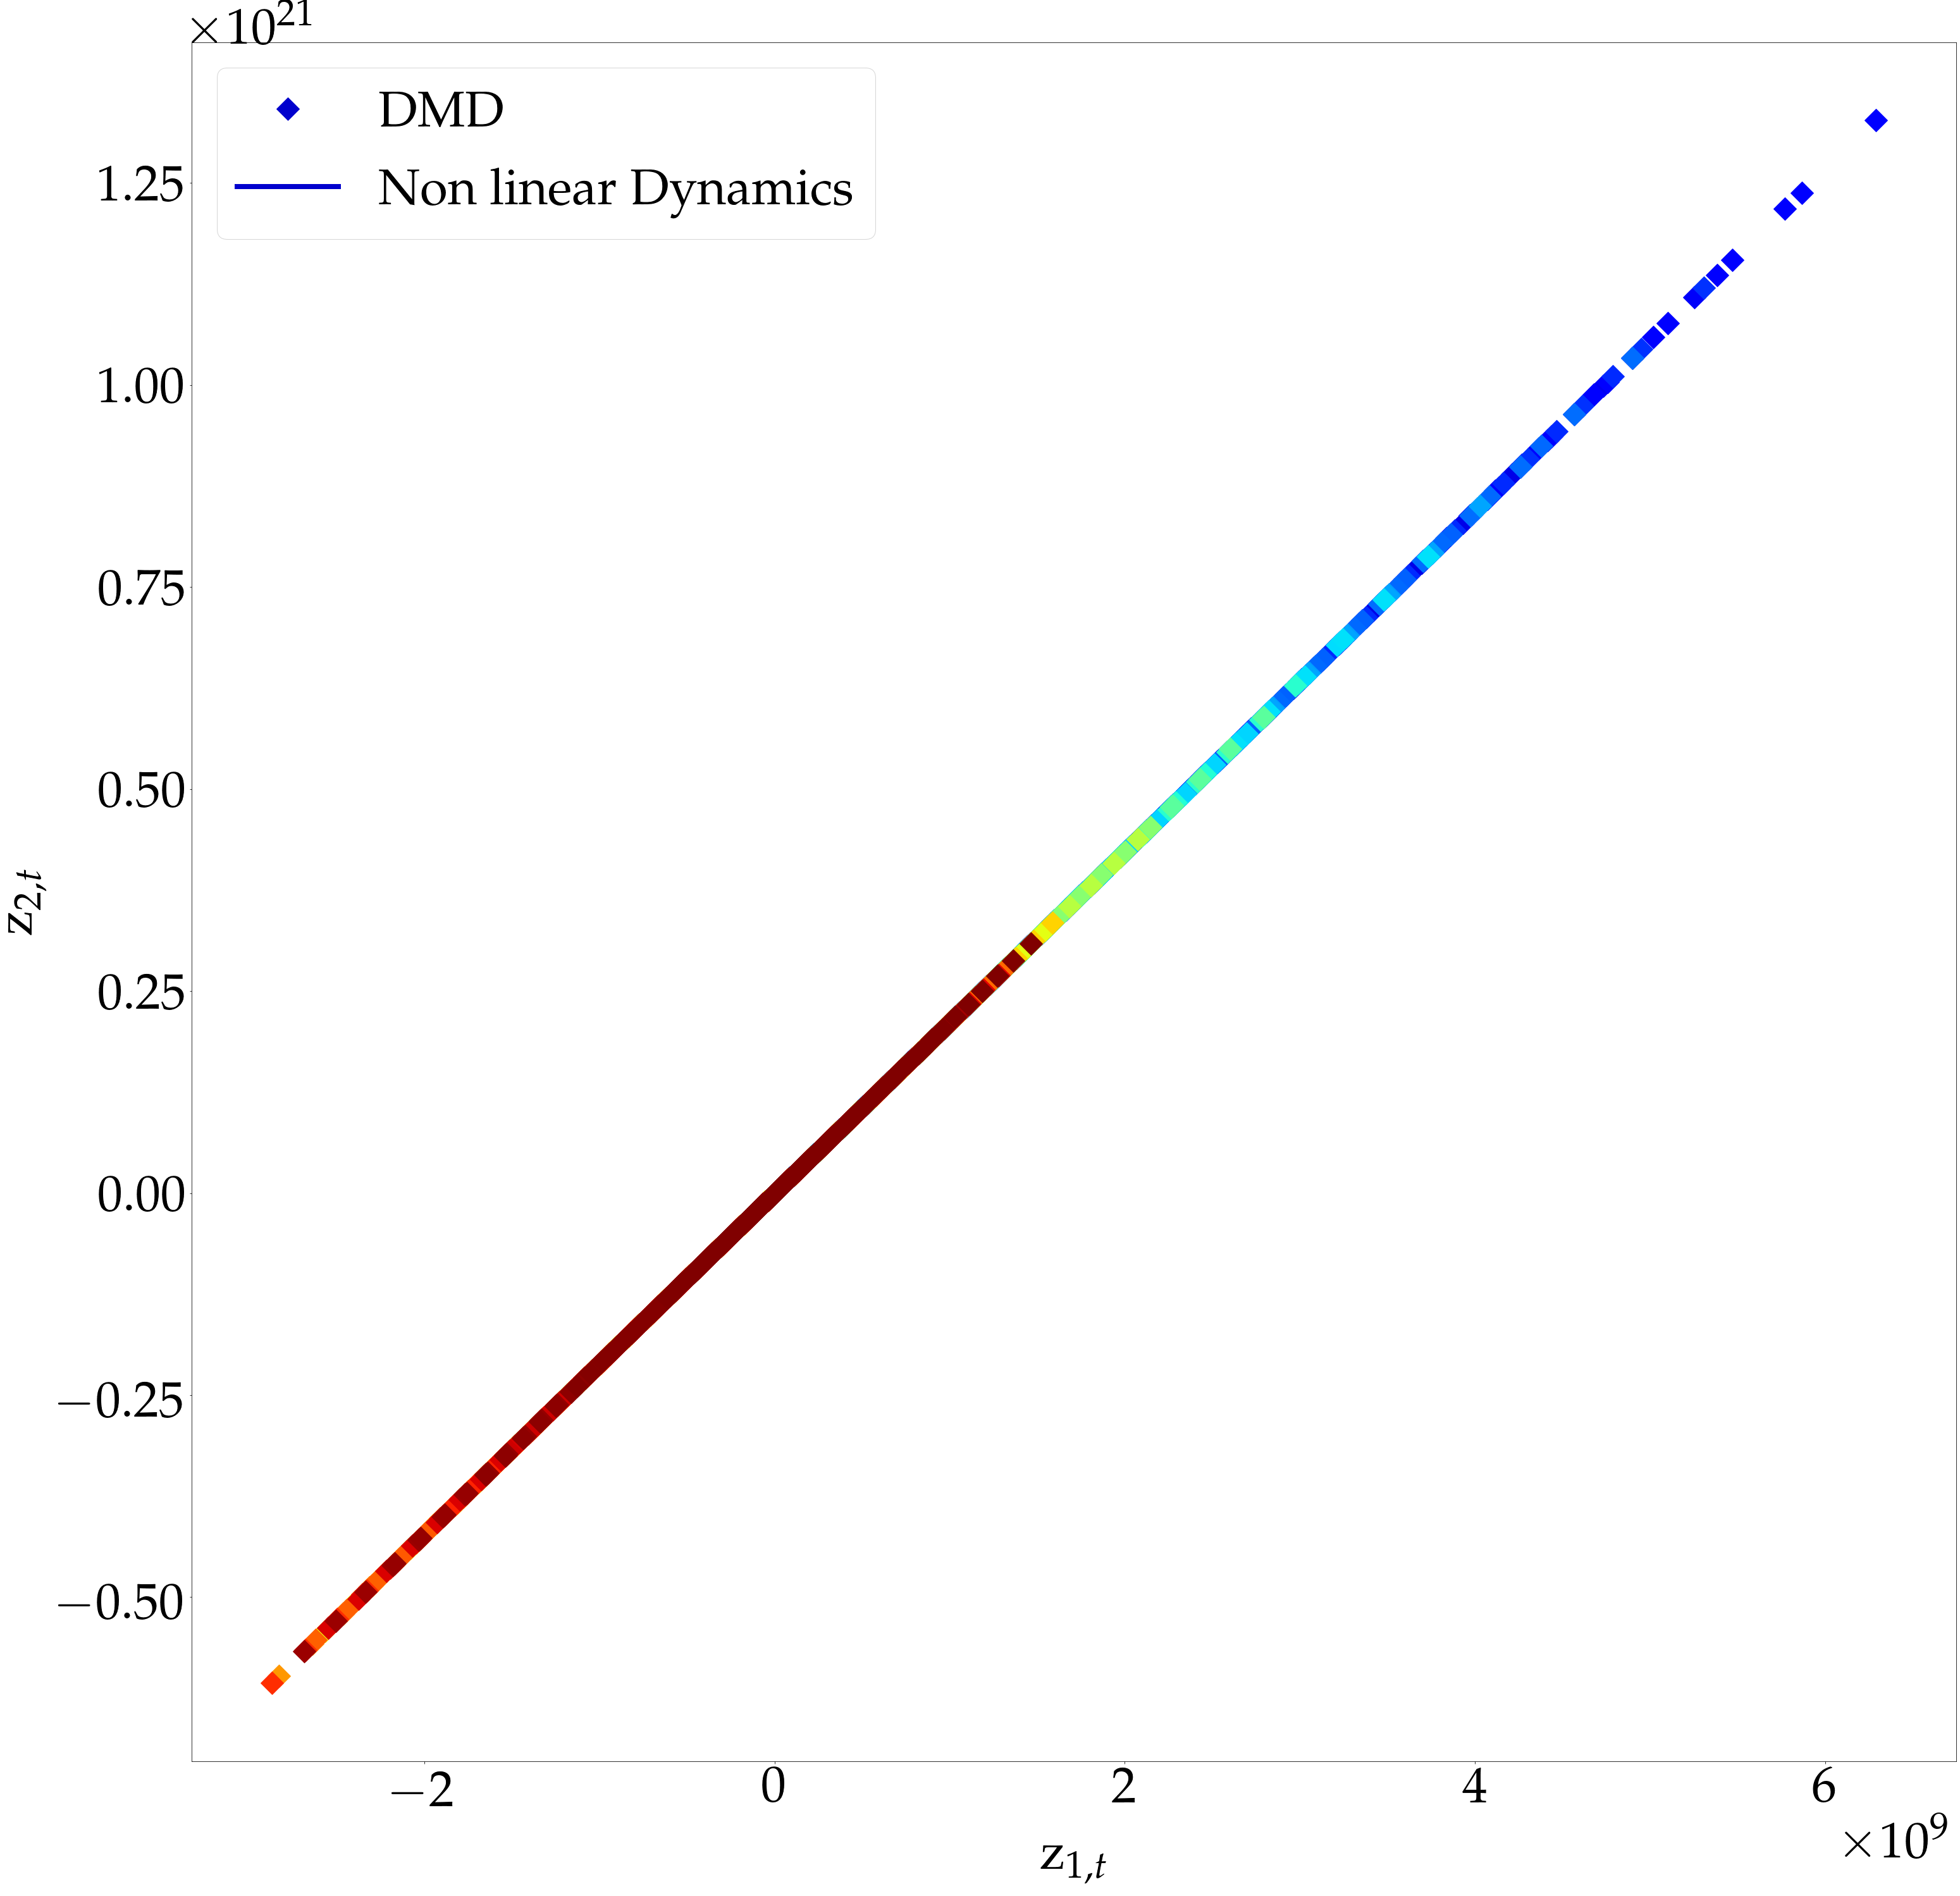

In [15]:
threshholded_pred = res['pred_DMD']
threshholded_test = res['test_data']
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
cmap = plt.get_cmap('jet')
fig=plt.figure(figsize=(50,50))
for i in range(0,threshholded_pred.shape[0],2):
    color = cmap(float(i+20)/300)
    plt.plot(threshholded_pred[i,1:,0],threshholded_pred[i,1:,1],"D",markersize=25,c = color)
    plt.plot(threshholded_test[i,:,0],threshholded_test[i,:,1],c = color,lw = 8)
plt.plot(threshholded_pred[i,1:,0]*np.nan,threshholded_pred[i,1:,1]*np.nan,"D",markersize=25,c = cmap(float(0+20)/300),label = 'DMD')
plt.plot(threshholded_test[i,:,0]*np.nan,threshholded_test[i,:,1]*np.nan,c = cmap(float(0+20)/300),lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')


# What if we pick a wrong observable (z1^2)

In [16]:
Batch_size = S_train.shape[1]
X_train = S_train[:,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = S_train.shape[0]
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
X_test  = torch.from_numpy(X_test).double()
Train_X_DMD = X_train[:,:-1,:].reshape(-1,2).numpy()
Train_Y_DMD = X_train[:,1:,:].reshape(-1,2).numpy()

In [17]:
Train_X_EDMD = np.zeros((Train_X_DMD.shape[0],3))
Train_X_EDMD[:,0] = Train_X_DMD[:,0]
Train_X_EDMD[:,1] = Train_X_DMD[:,1]
Train_X_EDMD[:,2] = Train_X_DMD[:,1]**2
Train_Y_EDMD = np.zeros((Train_X_DMD.shape[0],3))
Train_Y_EDMD[:,0] = Train_Y_DMD[:,0]
Train_Y_EDMD[:,1] = Train_Y_DMD[:,1]
Train_Y_EDMD[:,2] = Train_Y_DMD[:,1]**2

In [18]:
A_DMD  = np.dot(np.linalg.pinv(Train_Y_DMD),Train_X_DMD).T

In [19]:
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD),Train_Y_EDMD).T

In [20]:
A_DMD

array([[ 1.01005017e+00,  2.94927876e-13],
       [-6.04432671e-01,  1.07228830e+00]])

In [21]:
A_EDMD

array([[ 9.90049834e-01,  1.57167682e-13, -3.65040707e-15],
       [ 1.00692177e+00,  7.78091488e-01,  1.32268204e-03],
       [ 6.67987087e+01, -1.43379076e+01,  1.08247468e+00]])

In [22]:
red_DMD  = np.zeros_like(X_test)
pred_EDMD = np.zeros((X_test.shape[0],X_test.shape[1],3))# np.zeros_like(X_test)
pred_DMD[:,:3]  = X_test[:,:3,:]
pred_EDMD[:,:3,:2] = X_test[:,:3,:]
pred_EDMD[:,:3,2]  = pred_EDMD[:,:3,1]**2 
for j in range(X_test.shape[0]):
    for i in range(X_test.shape[1]):
        pred_DMD[j,3+i:3+i+1,:] = np.dot(A_DMD,pred_DMD[j,3+i-1:3+i,:].T).T
        pred_EDMD[j,3+i:3+i+1,:] = np.dot(A_EDMD,pred_EDMD[j,3+i-1:3+i,:].T).T

In [23]:
out_res = {}
out_res['train_data'] = X_train.detach().numpy() 
out_res['test_data'] = X_test.detach().numpy()
out_res['dt']  =dt
out_res['pred_EDMD'] = pred_EDMD
out_res['pred_DMD'] = pred_DMD

file_name_results = 'DMD_EDMD_EQ_Point_bad_observable'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results") 

pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/DMD_EDMD_EQ_Point_bad_observable/  already exists, overwriting results


In [24]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

Text(0, 0.5, '${\\mathrm{z}}_{2,t}$')

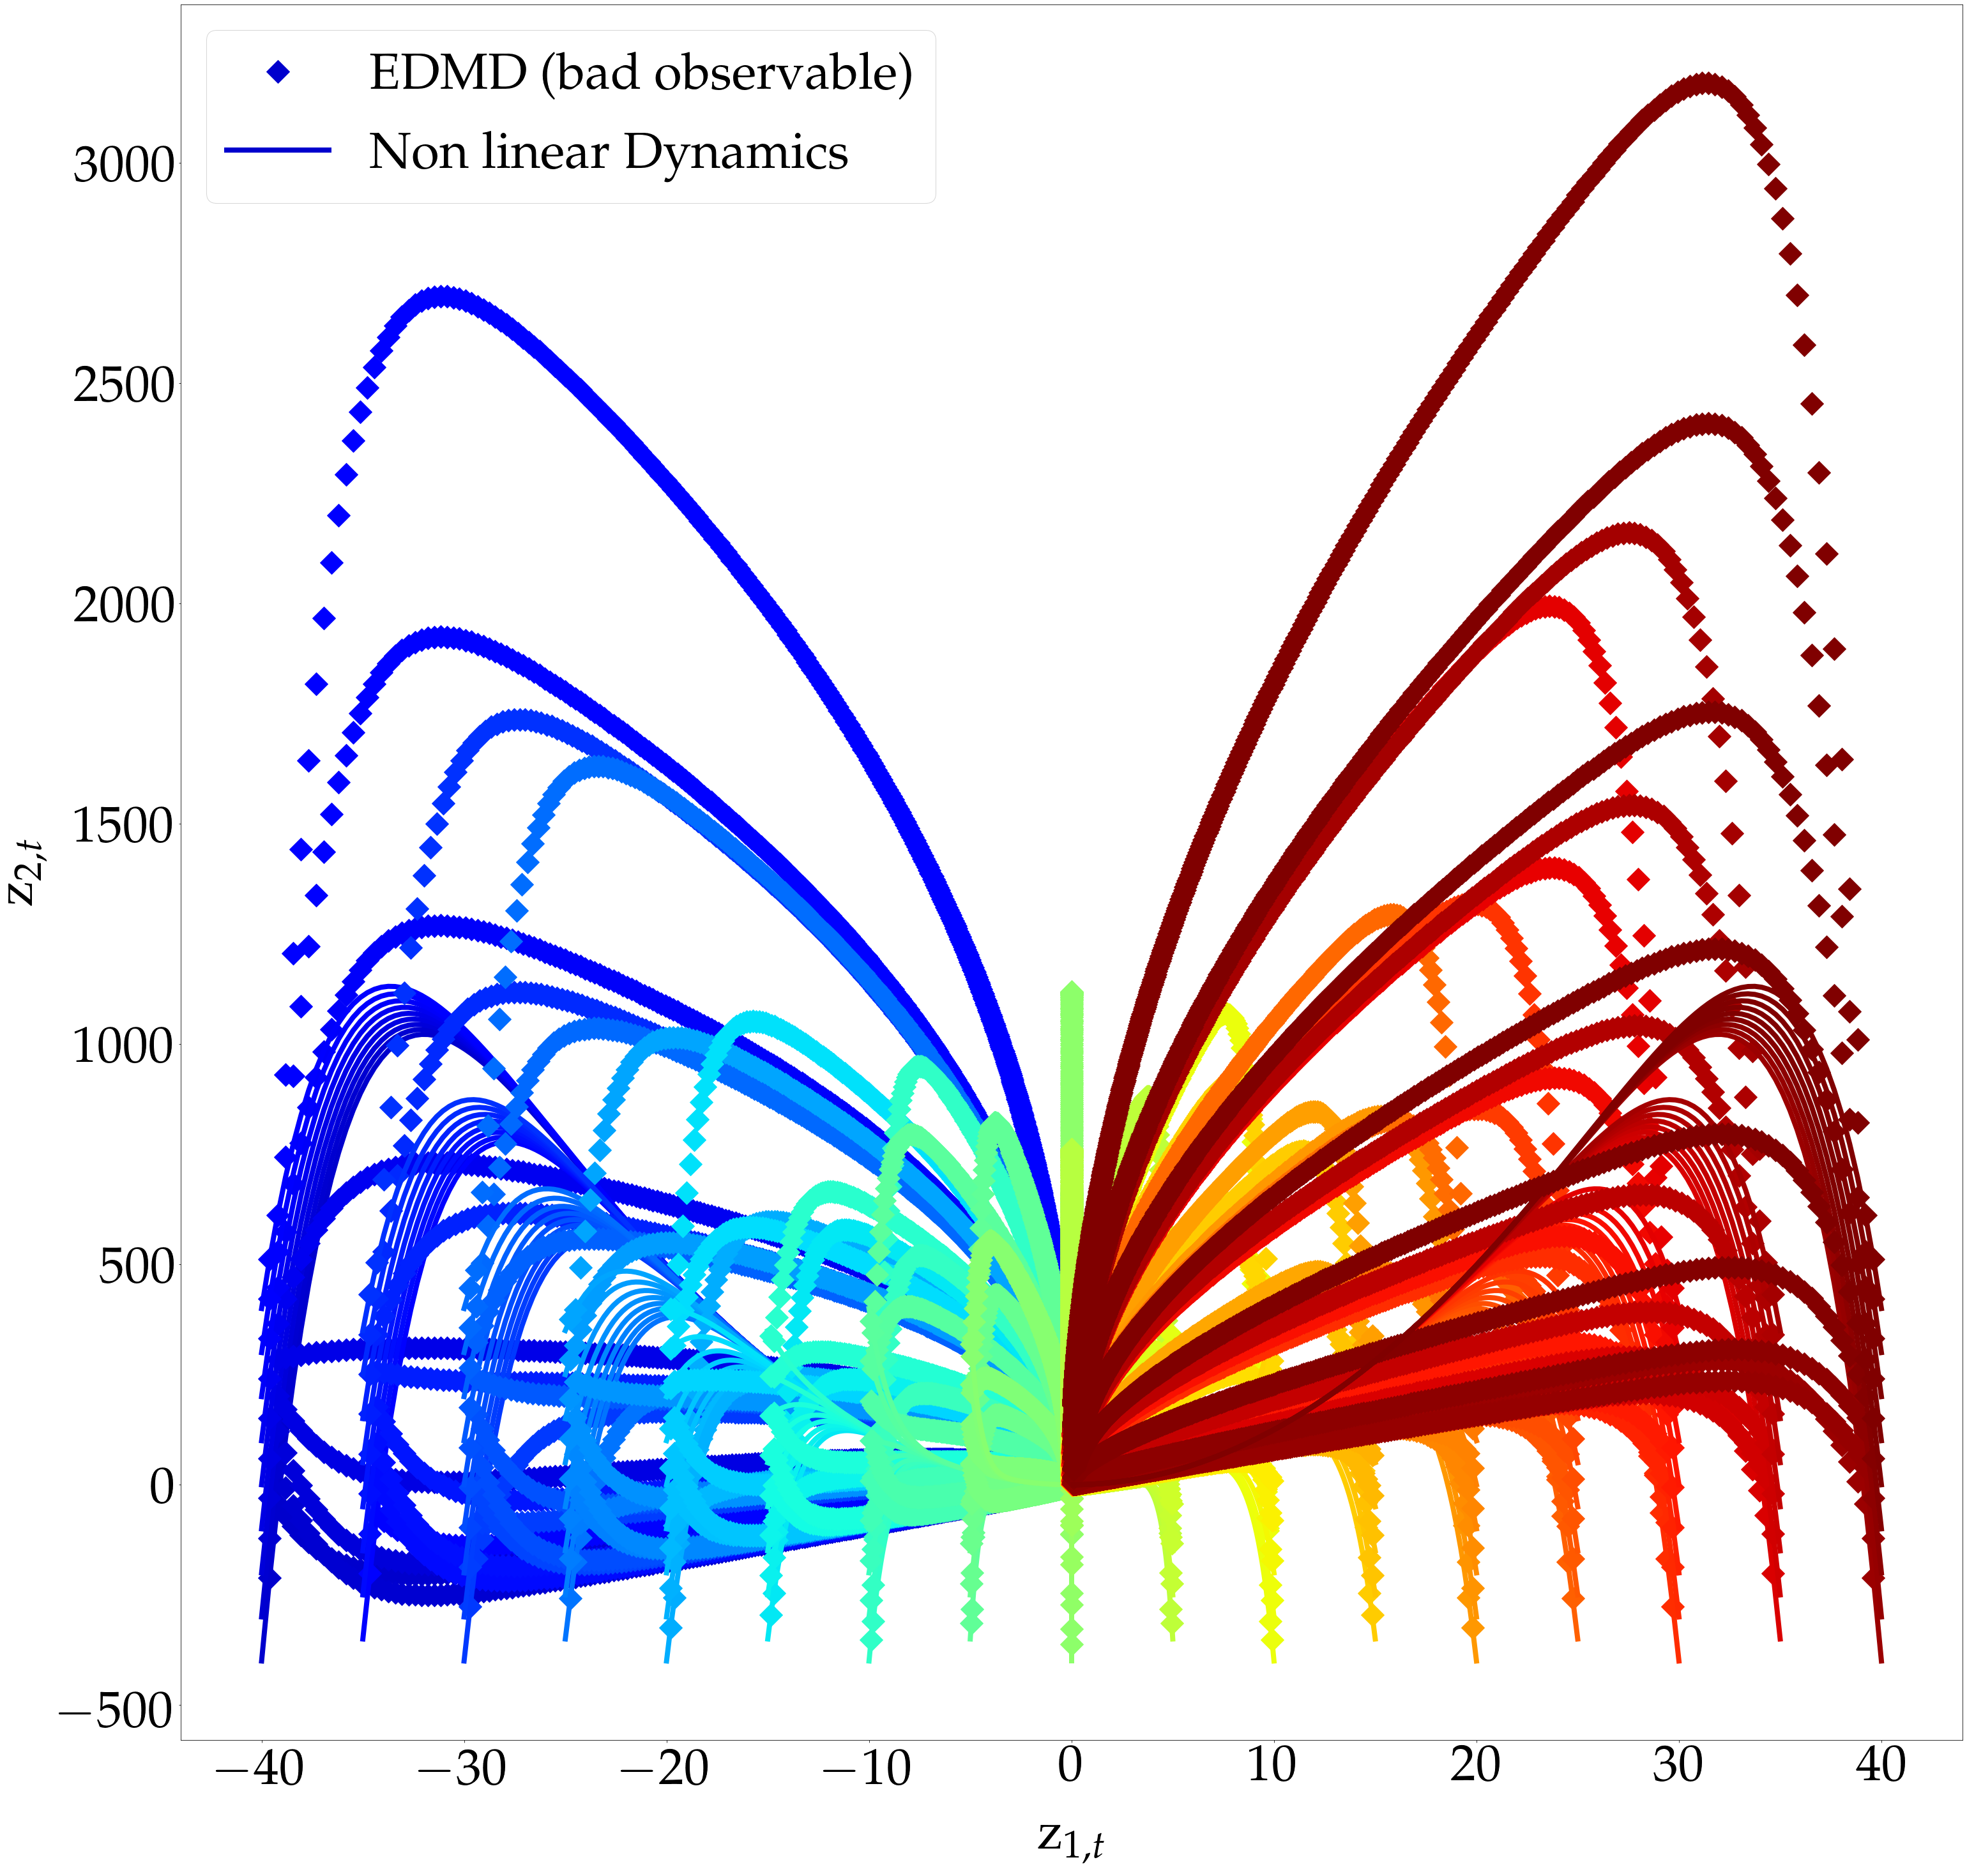

In [25]:
threshholded_pred = res['pred_EDMD']
threshholded_test = res['test_data']
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
cmap = plt.get_cmap('jet')
fig=plt.figure(figsize=(50,50))
for i in range(0,threshholded_pred.shape[0],2):
    color = cmap(float(i+20)/300)
    plt.plot(threshholded_pred[i,1:,0],threshholded_pred[i,1:,1],"D",markersize=25,c = color)
    plt.plot(threshholded_test[i,:,0],threshholded_test[i,:,1],c = color,lw = 8)
plt.plot(threshholded_pred[i,1:,0]*np.nan,threshholded_pred[i,1:,1]*np.nan,"D",markersize=25,c = cmap(float(0+20)/300),label = 'EDMD (bad observable)')
plt.plot(threshholded_test[i,:,0]*np.nan,threshholded_test[i,:,1]*np.nan,c = cmap(float(0+20)/300),lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')


Text(0, 0.5, '${\\mathrm{z}}_{2,t}$')

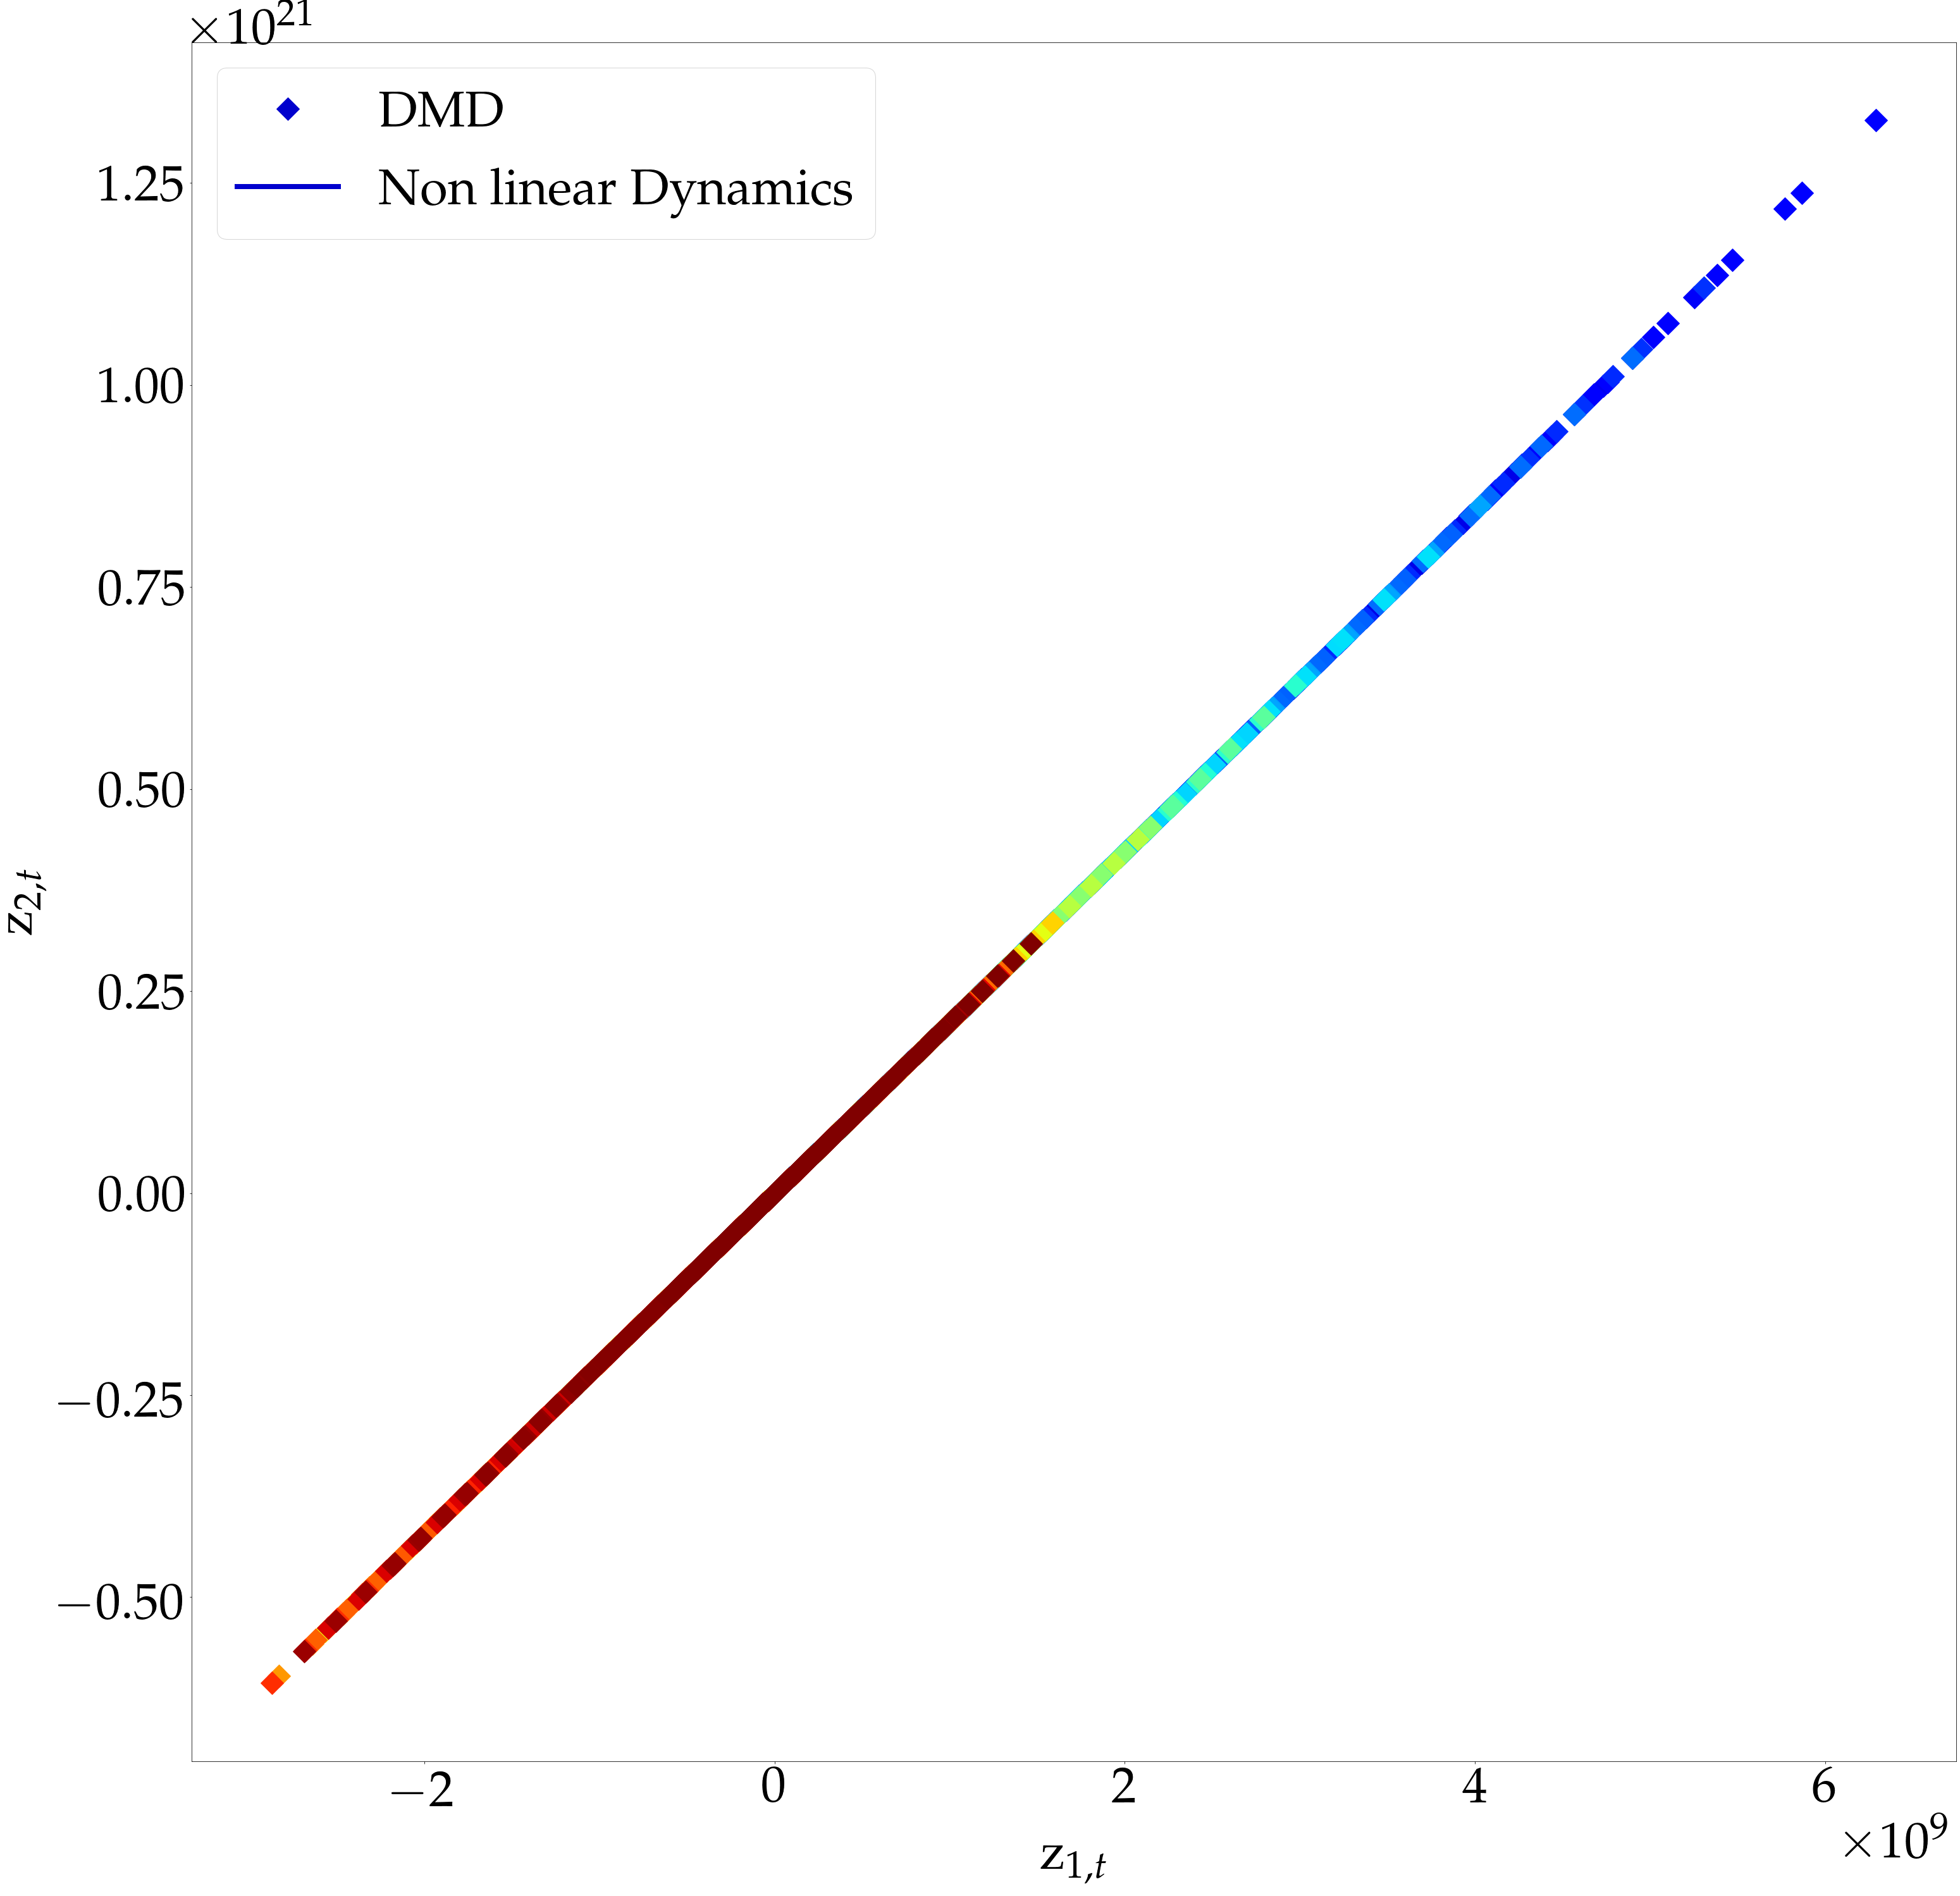

In [26]:
threshholded_pred = res['pred_DMD']
threshholded_test = res['test_data']
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
cmap = plt.get_cmap('jet')
fig=plt.figure(figsize=(50,50))
for i in range(0,threshholded_pred.shape[0],2):
    color = cmap(float(i+20)/300)
    plt.plot(threshholded_pred[i,1:,0],threshholded_pred[i,1:,1],"D",markersize=25,c = color)
    plt.plot(threshholded_test[i,:,0],threshholded_test[i,:,1],c = color,lw = 8)
plt.plot(threshholded_pred[i,1:,0]*np.nan,threshholded_pred[i,1:,1]*np.nan,"D",markersize=25,c = cmap(float(0+20)/300),label = 'DMD')
plt.plot(threshholded_test[i,:,0]*np.nan,threshholded_test[i,:,1]*np.nan,c = cmap(float(0+20)/300),lw = 8,label = 'Non linear Dynamics')
plt.legend()
plt.xlabel('${\mathrm{z}}_{1,t}$',labelpad = 40)
plt.ylabel('${\mathrm{z}}_{2,t}$')
